# Calibration of multiple parameters for ASPICS model, using ABC method

This jupyter notebook is based on the previous efforts from DyME and Prof Nick Malleson (University of Leeds)

- [RAMP-UA Initiative](https://github.com/Urban-Analytics/RAMP-UA/blob/d5973dff007645f1700cded93aaf72298ef84c61/experiments/calibration/abc-1.ipynb)

- [Calibrating Agent-Based Models Using Uncertainty Quantification Methods](https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipyn)

As SPC (Synthetic Population Catalyst) is a tool that helps urban modelling researchers to get synthetic population datasets at national level (currently limitated to England). This tool opens up new challenges/possibilities where external models (multi-level) like Agent-based models -ABM now can be tested in multi regions. However in models with location parameters striclty dependend on the population interactions, internal validation and calibrations process are seen as a relevant and requiered to properly tune this national behaivor. 

### ToDO to make progress in this experiment
- [X] Read the Synt Pop file - Translate to snaphot then ASPICS can read the new dataset.
- [] Read and plot the attributes we need, we could plot
- [] Read the baseline use as priors - Areas to test Leeds ( ideally West Yorkshire), Liverpool, Devon, Manchester (Grand Manchester)

## Background Concepts

- Uncertanity of ABM
- Methods for Calibration
- ABC

In [1]:
import math
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import random
from yaml import load, SafeLoader
sys.path.append('../')
from run_aspics import OpenCLRunner
from aspics.params import Params
from aspics.disease_statuses import DiseaseStatus
from aspics.loader import setup_sim
from headless import run_headless
import synthpop_pb2
import convert_snapshot

The following function is based on [SPC scripts](https://github.com/alan-turing-institute/uatk-spc/blob/main/python/protobuf_to_csv.py) the idea is to read the .pb file created with the tool. However, we need to make a translation from the proto file to snapshot which will integarte the data in the way ASPICS need it.

## Read the baseline data. Defined as prior to calibrate the model to a given area
Real observations (number of cases, deaths or hospital admission in the given area)
They need to be made cumulative as this is how they will be compared to the model.

#### Rutland area as test run due it size
The data for no of cases and the gam_cases data were created using [Ramp-UA - Observation Data](https://github.com/Urban-Analytics/RAMP-UA/tree/master/experiments/calibration/observation_data)

In [ ]:
# New per day:
gam_cases = pd.read_csv(os.path.join("baseline_data", "gam_manchester_cases.csv"), header=0, names=["Day", "Cases"], )
# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )
assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

## Run ASPIC using the default parameters

The following cells provide a set of plots to define how the model run with the default parameters ( manually calibrated for Devon area). In this example we use Rutland.

Before everything, we need to translate the .pb (protobufer) file to the snapshot required by ASPCIS [Usage guide](docs/usage_guide.md). You need to do this one time. Once you created your synthetic population file, then run 'run ../convert_snapshot.py -i SPC_data/{YOUR_NEW_AREA}.pb -o ../data/snapshots/{YOUR_NEW_AREA}/cache.npz'


Great now we have the cache.npz file in `data/snapshots`


In [2]:
os.getcwd()

'/Users/fbenitez/Documents/ResearchATI/uatk-aspics/uatk-aspics/calibration'

In [3]:
os.chdir("../") #Now we need to update the main directory then we can use aspics as the way was created.

In [27]:
df = pd.read_csv("data/bmi_scenarios/Current.csv")
df

,susceptible,exposed,presymptomatic,asymptomatic,symptomatic,recovered,Day,Current,Scenario 1,Scenario 2,Scenario 3,Scenario 4
0,177157,18,0,4,247,26,1,8,8,8,4,2
1,177120,50,1,8,205,62,2,14,14,16,9,7
2,177103,52,1,23,157,106,3,18,18,21,12,10
3,177080,46,2,50,121,140,4,21,22,28,15,12
4,177070,34,5,67,92,168,5,24,24,35,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...
295,164521,0,0,0,0,12784,296,155,141,194,121,108
296,164521,0,0,0,0,12784,297,155,141,194,121,108
297,164521,0,0,0,0,12784,298,155,141,194,121,108
298,164521,0,0,0,0,12784,299,155,141,194,121,108


In [37]:
filtered_data = df.loc[:,['Current', 'Scenario 1','Scenario 2', 'Scenario 3', 'Scenario 4']]
filtered_data

,Current,Scenario 1,Scenario 2,Scenario 3,Scenario 4
0,8,8,8,4,2
1,14,14,16,9,7
2,18,18,21,12,10
3,21,22,28,15,12
4,24,24,35,17,13
...,...,...,...,...,...
295,155,141,194,121,108
296,155,141,194,121,108
297,155,141,194,121,108
298,155,141,194,121,108


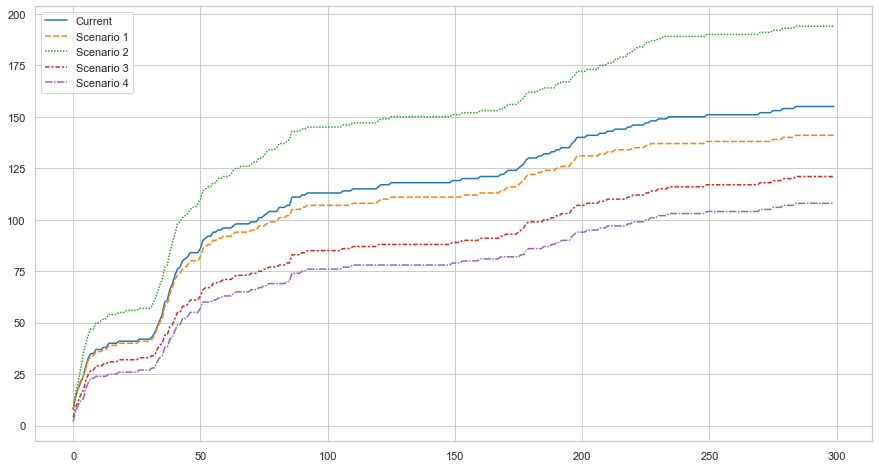

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,8))
ax = sns.lineplot(data=filtered_data, palette="tab10", linewidth=1.5)

In [ ]:
PARAMETERS_FILE = 'config/new_parameters.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

simulator, snapshot, study_area, iterations = setup_sim(parameters)  #Initial configuration, based on the parameters to run the model
summary, final_state = run_headless(simulator, snapshot, iterations, quiet=False, store_detailed_counts=True) #run the model in a headless mode

In [17]:
#oddRatio=2.89
#knownProb = 0.005

def odd_ratio_to_proba (oddRatio,knownProb):
   return oddRatio * knownProb / (1 + oddRatio * knownProb - knownProb)

#print(odd_ratio_to_proba(oddRatio,knownProb))


In [18]:
new_bmi = 6.253716
female_mortality= 1.0
male_mortality= 1.19
sex = 0
age = 37
mortality= 0.002
cvd= 1.0
bloodpressure=1.0
bloodpressure_multiplier=12.0
diabetes=1.0
diabetes_multiplier=1.47
age_mortality_multipliers=[0.0088, 0.0219, 0.0921, 0.3245, 1.0,  2.8916, 8.4749, 24.4236, 106.7409]
BMI = [5.7, -0.3, 0.0061, 2.340, -0.13, 0.003, 9.407, -0.67, 0.014, 9.21, -0.646, 0.012]
ethnicity_multipliers=[1.0, 1.74, 2.55, 2.97]
origin= 1

oddSex = ((1.0 - sex) * female_mortality) + sex * male_mortality
probaSex = odd_ratio_to_proba(oddSex,mortality)
oddAge = age_mortality_multipliers[int(min(age/10,8))]
probaAge = odd_ratio_to_proba(oddAge,probaSex)
oddCVD = max(cvd * cvd, 1.0);
probaCVD = odd_ratio_to_proba(oddCVD,probaAge)
oddDiabetes = max((diabetes * diabetes_multiplier), float(1.0))
probaDiabetes = odd_ratio_to_proba(oddDiabetes,probaCVD)
oddHypertension = max(bloodpressure * bloodpressure_multiplier, float(1.0))
probaHypertension = odd_ratio_to_proba(oddHypertension,probaDiabetes)
originNew = min(origin, 4)
probaOrigin = odd_ratio_to_proba(ethnicity_multipliers[origin - 1],probaHypertension)
oddBMI = (BMI[originNew-1]*3) + (BMI[originNew-1]*3+1) * new_bmi + (BMI[originNew-1]*3+2) * pow(new_bmi,2)
personal_mortality_final = odd_ratio_to_proba(oddBMI,probaOrigin)
print(oddSex,probaSex, oddAge, probaAge, oddCVD, probaCVD, oddDiabetes,probaDiabetes, oddHypertension, probaHypertension, originNew, probaOrigin, oddBMI, personal_mortality_final)


1.0 0.002 0.3245 0.0006498779851579485 1.0 0.0006498779851579485 1.47 0.0009550289316115979 12.0 0.011341204219698768 1 0.011341204219698768 877.2734683453297 0.9096124405668748


In [67]:
if (new_bmi < 0 ):
    new_bmi *= -1
print (new_bmi)    

1


In [22]:
age_mortality_multipliers[1]

0.0219

## Run ASPICS using parameters manually defined.


In [ ]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

In [ ]:
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]

In [ ]:
params_manual = OpenCLRunner.create_params_manually( parameters_file=PARAMETERS_FILE)

In [ ]:
REPETITIONS = 5
ITERATIONS = 100
STUDY_AREA = "Manchester"
OUTPUT = True
OUTPUT_EVERY_ITERATION = False
USE_LOCKDOWN = False
START_DATE = 10
#OBSERVATIONS IS DECLARED IN THE PREVIOUS CELL
USE_GPU = True
USE_HEALTHIER_POP = True
STORE_DETAILED_COUNTS = True
#PARAMETERS file IS DECLARED IN THE PREVIOUS CELL

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

In [ ]:
OpenCLRunner.init(
    iterations = ITERATIONS,
    repetitions = REPETITIONS,
    study_area= STUDY_AREA,
    output=OUTPUT,
    output_every_iteration=OUTPUT_EVERY_ITERATION,
    use_lockdown=False,
    start_date=START_DATE,
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,
    use_healthier_pop = True
)

In [ ]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline, initially suggested as 10
OpenCLRunner.update(store_detailed_counts=True)

In [ ]:
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_aspics_with_params_abc({}, return_full_details=True)

In [ ]:
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()

In [ ]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))

    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations

    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)

        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue

        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}",
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"],
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")


    ax.legend()
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

In [ ]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [ ]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2),
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]

            ax.flat[d].legend()
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

In [ ]:
plot_disease_status_by_age(summaries0)

# ABC

In [ ]:
import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
import pickle

In [ ]:
import itertools

In [ ]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

In [ ]:
# The following should all be constant (overriding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0 })
# FYI this is how to represent with discrete distributions and one possible value
# https://pyabc.readthedocs.io/en/latest/api_random_variables.html#

current_risk_beta_rv = current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = { "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
           "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv,
           "current_risk_beta":current_risk_beta_rv}

fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True, sharey=True)
x = np.linspace(0,2,49)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, variable in enumerate([retail_rv, primary_school_rv, secondary_school_rv, work_rv,
                              ]):
    var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    #ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

#ax.legend()
fig.suptitle("Priors")
fig.tight_layout()

In [ ]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution(
    #home = home_rv,
    retail = retail_rv,
    primary_school = primary_school_rv,
    secondary_school = secondary_school_rv,
    work = work_rv,
    presymptomatic = presymptomatic_rv,
    symptomatic = symptomatic_rv,
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0), # TODO why is it like this.
    current_risk_beta = current_risk_beta_rv
)

In [ ]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_aspics_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
)

In [ ]:
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

In [ ]:
os.getcwd()

In [ ]:
db_path = ("sqlite:///" + os.path.join(".", "abc-manchester.db"))

In [ ]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

In [ ]:
LOAD_PICKLES = True
history = None
fname = "abc_2-manchester.pkl"

if LOAD_PICKLES and os.path.isfile(fname):
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    history = abc.run(max_nr_populations=2)
    # The history object only works if it has the associated database too ('abc-1.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

In [ ]:
fig, ax = plt.subplots()

for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w,x="asymptomatic", ax=ax,label="PDF t={}".format(t))
#ax.axvline(y_observed, color="k", linestyle="dashed");
ax.axvline(x=0.53, color="grey", linestyle="dashed");
ax.legend()

In [ ]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5},
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

In [ ]:
fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,10))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                                        label=f"{param} PDF t={t}",
                                        alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
                                        color= "black" if t==history.max_t else None # Make the last one black
                                        )
        if param!="work":
            ax.set_xlim(0,1)
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [ ]:
# As above but only show two parameters (for a Turing presentation)
fig, axes = plt.subplots(1,2, figsize=(12,6))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(['primary_school', 'asymptomatic']):
    ax = axes.flat[i]
    t = history.max_t
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                                    label=f"{param} PDF t={t}",
                                    alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
                                    color= "black" if t==history.max_t else None # Make the last one black
                                    )
    if param!="work":
        ax.set_xlim(0,1)
    ax.legend(fontsize="small")
    ax.set_title(f"{param}")
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
for t in range(history.max_t + 1):
   ax = axes.flat[t]
   for i, param in enumerate(priors.keys()):
       df, w = history.get_distribution(m=0, t=t)
       pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
           label=f"{param}")
   ax.legend()
   ax.set_title(f"t={t}")
fig.tight_layout()

In [ ]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

# Posterior

In [ ]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

In [ ]:
N_samples = 50
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx]

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()

    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}

    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_aspics_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])


# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")

pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)